In [66]:
import numpy as np
from qiskit.opflow import I, X, Y, Z, MatrixEvolution, PauliTrotterEvolution, Zero , One
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit import QuantumCircuit, execute
import pylatexenc
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from matplotlib import pyplot as plt
import math 
import time

In [67]:
def depth(qc):
  depth_list = []
  depth_list.append(qc.depth())
  for i in range(5):
    qc = qc.decompose()
    depth_list.append(qc.depth())
  if(depth_list[-1]==depth_list[-2]):
    return depth_list[-1]
  else:
    while(depth_list[-1]!=depth_list[-2]):
      qc = qc.decompose()
      depth_list.append(qc.depth())
    else:
      return depth_list[-1]

##GRAY CODE ENCODING

PARAMETERS

In [68]:
#Harmonic Oscillator Parameters

Np = 1 # Has to be of the form 2^M - 1
N = 2  # Number of oscillators

hbar = 1
m = 1
omega = 1

#Trotterization Parameters

num_qubits = (np.log2(Np+1))

if(math.modf(num_qubits)[0]>0):
  num_qubits = N*(int((np.log2(Np+1)))+1)
else:
  num_qubits = N*int((np.log2(Np+1)))

num_states = 2**(num_qubits)

t = Parameter('t')
evolution_time_t = 0.1
time_step_value_t = 0.1
steps_t = int(evolution_time_t/time_step_value_t)

#Perturbation Parameters

lamda = 1

In [69]:
#Create circuit

qc = QuantumCircuit(num_qubits,num_qubits)
harmonic_oscillator = QuantumCircuit(num_qubits)
statec = QuantumCircuit(num_qubits)

sim = QasmSimulator()
options = {'method': 'statevector'}
execute(qc, sim, backend_options=options)

In [70]:
#Preparing the intial state

statec.x(0)
# statec.x(5)
# statec.x(3)

In [71]:
mygate1 = statec.to_gate()
index = list(np.arange(0,num_qubits,1))
qc = qc.compose(mygate1,index)

In [72]:
intial_state = qi.Statevector.from_instruction(qc)
intial_state.draw('latex', prefix='State:')

<IPython.core.display.Latex object>

In [73]:
def GrayCode(n):
    ret = []
    for i in range(1 << n):
        val = (i ^ (i >> 1))
        s = bin(val)[2::]
        ret.append(s.zfill(n))
    string = int(num_qubits/N)*'0'
    ret.append(string)
    return ret

In [74]:
def TransitionSeq(seq1, seq2):
  n = len(seq1)
  j = n
  for i in range(n):
    if seq1[i] != seq2[i]:
      return j-1
    j -= 1

In [75]:
#Our Graycode Sequence

Glist = GrayCode(int(num_qubits/N))

print(Glist)

['0', '1', '0']


In [76]:
#Obtaining our Hamiltonian

#Hamiltonian 
H_ = 0
H  = 0
H_list = []
#Number Operator
Num_ = 0
Num  = 0
Num_list = []
#Identity Operator 
Id1 = 1
Id2 = 1
#Position Operator
X_  = 0 
_X_ = 0
_X_list = []
_X_op_list = []
#Momentum Operator
P_  = 0 
_P_ = 0 
_P_list = []

#Making the Identity Operator
for i in range(int(num_qubits/N)):
    Id1 = Id1 ^ I
for i in range(num_qubits):
    Id2 = Id2 ^ I 

#Making the Unperturbed Hamiltonian of a single Harmonic Oscillator
for i, state in enumerate(Glist[:-1]):
  temp = 1
  for j in(state):
    if(j == '0'):
        temp = temp ^ (0.5*(I+Z))
    else:
        temp = temp ^ (0.5*(I-Z))
  
  #Number operator and Hamiltonian for a particular oscillators
  Num_ += i*temp
H_ +=((hbar*omega)*((Num_)+0.5*(Id1)))

In [77]:
#Getting the Anhilation and Creator operators

#Anhilation operator
a        = 0
a_list   = []
#Creation operator
a_dagger      = 0
a_dagger_list = []

#Creation Operator in Opflow format
for i,state in enumerate(Glist[:-1]): 
  if(state!=Glist[-2]):
    temp = 1
    for k, j in enumerate(state): 
      if((num_qubits//N)-k-1 == TransitionSeq(Glist[i], Glist[i+1]) and j == '0'): 
          temp = 0.5*(temp^(X + 1j*Y))
      elif((num_qubits//N)-k-1 == TransitionSeq(Glist[i], Glist[i+1]) and j == '1'):
          temp = 0.5*(temp^(X - 1j*Y))
      elif(j == '0'):
          temp =  temp^(0.5*(I+Z))
      else:
          temp = temp^(0.5*(I-Z))
  else:
    temp = 0 
  a+= math.sqrt(i+1)*temp


#Anhilation Operator in Opflow format
for i,state in enumerate(Glist[:-1]):
  if(state!=Glist[0]):
    temp = 1 
    for k, j in enumerate(state): 
      if((num_qubits//N)-k-1 == TransitionSeq(Glist[i-1], Glist[i]) and j == '0'): 
          temp = 0.5*(temp^(X + 1j*Y))
      elif((num_qubits//N)-k-1 == TransitionSeq(Glist[i-1], Glist[i]) and j == '1'):
          temp = 0.5*(temp^(X - 1j*Y))
      elif(j == '0'):
          temp = temp^(0.5*(I+Z))
      else:
          temp = temp^(0.5*(I-Z))
  else:
    temp = 0
  a_dagger+= math.sqrt(i)*temp

#Postion and Momentum Operator in Opflow format
X_ = (a+a_dagger)*np.sqrt((hbar)/(2*m*omega))
P_ = (a_dagger-a)*np.sqrt((hbar*m*omega)/2)*1j


#Making all the matrices for every operator for a particular oscillator(Keeping dimensions of the composite system Eg: H1 = H_^I^...^I)
for i in range(N):
  temp1 = 1
  temp2 = 1
  temp3 = 1
  temp4 = 1
  temp5 = 1
  temp6 = 1

  for j in range(N):
    if(i==j):
      temp1 = H_^temp1
      temp2 = Num_^temp2
      temp3 = X_^temp3
      temp4 = P_^temp4
      temp5 = a^temp5
      temp6 = a_dagger^temp6
    else:
      temp1 = Id1^temp1
      temp2 = Id1^temp2
      temp3 = Id1^temp3
      temp4 = Id1^temp4
      temp5 = Id1^temp5
      temp6 = Id1^temp6
  
  H_list.append(temp1.to_matrix())
  Num_list.append(temp2.to_matrix())
  _X_list.append(temp3.to_matrix())
  _X_op_list.append(temp3)
  _P_list.append(temp4.to_matrix())
  a_list.append(temp5.to_matrix())
  a_dagger_list.append(temp6.to_matrix())

  H   += temp1  
  Num += temp2
  _X_ += temp3
  _P_ += temp4
  
#Adding coupling terms and perturbations

for i in range(1,N):
  temp = (_X_op_list[i]-_X_op_list[i-1])@(_X_op_list[i]-_X_op_list[i-1])
  H += temp
  H_list[i] += temp.to_matrix()

#Adding  perturbation terms

#x perturbation 

# for i in range(N):
#   temp = lamda*(_X_op_list[i])
#   H_list[i] += temp.to_matrix()
#   H += temp

#x^3 perturbation

# for i in range(N):
#   temp = lamda*((_X_op_list[i])@(_X_op_list[i])@(_X_op_list[i]))
#   H_list[i] += temp.to_matrix()
#   H += temp

#Reducing the number of terms

H = H.reduce()
print(H.to_matrix().real)

[[ 2.  0.  0. -1.]
 [ 0.  3. -1.  0.]
 [ 0. -1.  3.  0.]
 [-1.  0.  0.  4.]]


In [78]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(H.to_matrix().real)

[[ 2.  0.  0. -1.]
 [ 0.  3. -1.  0.]
 [ 0. -1.  3.  0.]
 [-1.  0.  0.  4.]]


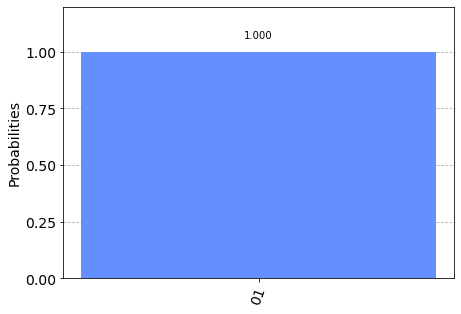

In [79]:
#Trotterization
time_evolution_operator=H*t
time_evolution_operator=time_evolution_operator.exp_i()
full_time_evolution_circuit=PauliTrotterEvolution().convert(time_evolution_operator)
full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
for i in range(steps_t-1):
    full_time_evolution_circuit@=PauliTrotterEvolution().convert(time_evolution_operator)
    full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
full_time_evolution_circuit=full_time_evolution_circuit.to_circuit()
full_time_evolution_circuit=harmonic_oscillator.compose(full_time_evolution_circuit)

mygate = full_time_evolution_circuit.to_gate()
index = list(np.arange(0,num_qubits,1))
qc = qc.compose(mygate,index)

#Final state

final_state = qi.Statevector.from_instruction(qc)
qc.measure(index,index)
backend = Aer.get_backend('qasm_simulator') 
job=execute(qc, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [43]:
#Circuit 
qc.decompose().decompose().decompose().decompose().draw('mpl').savefig('qc.png')

In [44]:
print("True depth of the circuit is : ", depth(qc))

True depth of the circuit is :  5


In [45]:
final_state.draw('latex', prefix='State:')

<IPython.core.display.Latex object>

In [46]:
#Getting the Expectation Values of obsevables
final_state = np.array(final_state)

exp_x = final_state.conjugate().T @ _X_list @ final_state
exp_p = final_state.conjugate().T @ _P_list @ final_state
exp_h = final_state.conjugate().T @  H_list @ final_state

In [47]:
print("Expectation Value of x : " , exp_x.real)
print("Expectation Value of p : " , exp_p.real)
print("Expectation Value of h : " , exp_h.real)

Expectation Value of x :  [0. 0. 0.]
Expectation Value of p :  [0. 0. 0.]
Expectation Value of h :  [1.5 0.5 0.5]


PERFORMING THE COMPUTATION FOR THE ENTIRE INTERVAL

In [48]:
#Getting the expectation values for an interval and plotting them
t_initial = 0
t_final = t_initial + 2*np.pi

t_ = np.arange(t_initial,t_final,0.3)
no_points = np.shape(t_)[0]
_x_ = np.zeros((no_points,N))
_p_ = np.zeros((no_points,N))
_h_ = np.zeros((no_points,N))

time_elapsed = np.zeros(no_points)
depth_time = np.zeros(no_points)
steps_time = np.zeros(no_points)


print("Total Iterations = ",no_points,"\n\n")
for i in range(no_points):
  QC = QuantumCircuit(num_qubits,num_qubits)
  HARMONIC_OSCILLATOR_circuit = QuantumCircuit(num_qubits)
  mygate1 = statec.to_gate()
  index = list(np.arange(0,num_qubits,1))
  QC = QC.compose(mygate1,index)

  steps_t = int(t_[i]/time_step_value_t)
  steps_time[i] = steps_t

  start = time.time()

  time_evolution_operator=H*t
  time_evolution_operator=time_evolution_operator.exp_i()
  full_time_evolution_circuit=PauliTrotterEvolution().convert(time_evolution_operator)
  full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
  for j in range(steps_t-1):
      full_time_evolution_circuit@=PauliTrotterEvolution().convert(time_evolution_operator)
      full_time_evolution_circuit=full_time_evolution_circuit.bind_parameters({t:time_step_value_t})
  full_time_evolution_circuit=full_time_evolution_circuit.to_circuit()
  full_time_evolution_circuit=HARMONIC_OSCILLATOR_circuit.compose(full_time_evolution_circuit)
  mygate = full_time_evolution_circuit.to_gate()
  index = list(np.arange(0,num_qubits,1))
  QC = QC.compose(mygate,index)


  stv = qi.Statevector.from_instruction(QC)

  sim = QasmSimulator()
  options = {'method': 'statevector'}
  execute(QC, sim, backend_options=options)


  stv = np.array(stv)

  _x_[i] = (stv.conjugate().T @ _X_list @ stv).real
  _p_[i] = (stv.conjugate().T @ _P_list @ stv).real
  _h_[i] = (stv.conjugate().T @  H_list @ stv).real
  

  end = time.time()
  time_elapsed[i] = end-start
  depth_time[i] = depth(QC)
  txt="iter no :{:<4}|iter time : {:10.5f}|Depth : {:<10}|Steps :{:<5}|"
  print(txt.format(i+1,time_elapsed[i],depth_time[i],steps_time[i]))

print("\n\n")
print("Total time taken = ",np.sum(time_elapsed)," s")

Total Iterations =  21 


iter no :1   |iter time :    0.05031|Depth : 4.0       |Steps :0.0  |
iter no :2   |iter time :    0.07373|Depth : 8.0       |Steps :2.0  |
iter no :3   |iter time :    0.18051|Depth : 20.0      |Steps :5.0  |
iter no :4   |iter time :    0.22962|Depth : 32.0      |Steps :8.0  |
iter no :5   |iter time :    0.35105|Depth : 44.0      |Steps :11.0 |
iter no :6   |iter time :    0.48258|Depth : 60.0      |Steps :15.0 |
iter no :7   |iter time :    0.49230|Depth : 68.0      |Steps :17.0 |
iter no :8   |iter time :    0.59133|Depth : 84.0      |Steps :21.0 |
iter no :9   |iter time :    0.60785|Depth : 92.0      |Steps :23.0 |
iter no :10  |iter time :    0.71020|Depth : 104.0     |Steps :26.0 |
iter no :11  |iter time :    0.85477|Depth : 120.0     |Steps :30.0 |
iter no :12  |iter time :    1.00136|Depth : 128.0     |Steps :32.0 |
iter no :13  |iter time :    0.96177|Depth : 140.0     |Steps :35.0 |
iter no :14  |iter time :    1.00707|Depth : 156.0     |Steps :3

In [49]:
_x_ = _x_.T
_p_ = _p_.T
_h_ = _h_.T

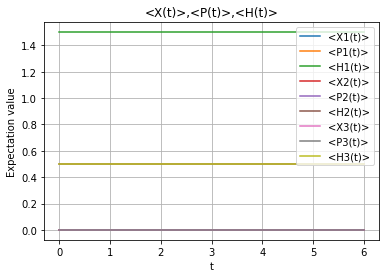

In [50]:
for i in range(N):
  plt.plot(t_,_x_[i],label="<X"+str(i+1)+"(t)>")
  plt.plot(t_,_p_[i],label="<P"+str(i+1)+"(t)>")
  plt.plot(t_,_h_[i],label="<H"+str(i+1)+"(t)>")

plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<X(t)>,<P(t)>,<H(t)>')
plt.grid()
# plt.savefig('|000000>+|000001>.svg', format='svg', dpi=1200)

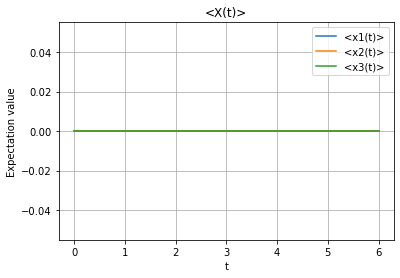

In [51]:
for i in range(N):
  plt.plot(t_,_x_[i],label="<x"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<X(t)>')
plt.grid()
plt.show()
# plt.savefig('X expectation.png')

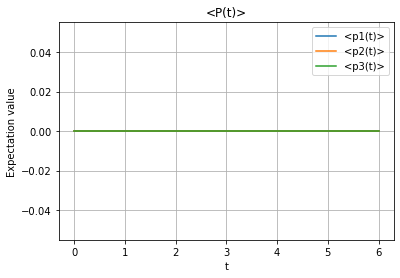

In [52]:
for i in range(N):
  plt.plot(t_,_p_[i],label="<p"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<P(t)>')
plt.grid()
plt.show()
# plt.savefig('P expectation.png')

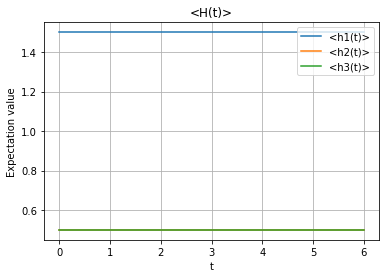

In [53]:
for i in range(N):
  plt.plot(t_,_h_[i],label="<h"+str(i+1)+"(t)>")
plt.xlabel('t')
plt.ylabel('Expectation value')
plt.legend(loc="upper right")
plt.title('<H(t)>')
plt.grid()
plt.show()
# plt.savefig('H expectation.png')

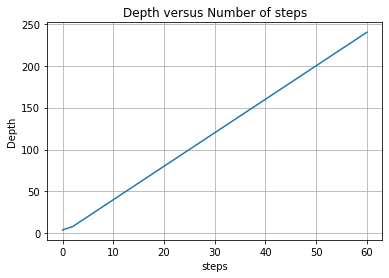

<Figure size 432x288 with 0 Axes>

In [54]:
plt.plot(steps_time,depth_time)
plt.xlabel('steps')
plt.ylabel('Depth')
plt.title('Depth versus Number of steps')
plt.grid()
plt.show()
plt.savefig('dvs_sup.svg', format='svg', dpi=1200)

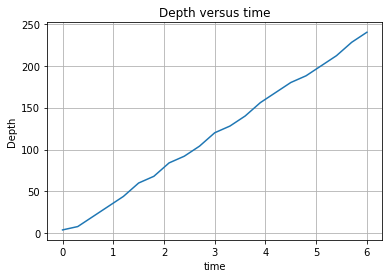

<Figure size 432x288 with 0 Axes>

In [55]:
plt.plot(t_,depth_time)
plt.xlabel('time')
plt.ylabel('Depth')
plt.title('Depth versus time')
plt.grid()
plt.show()
plt.savefig('dvt_sup.svg', format='svg', dpi=1200)

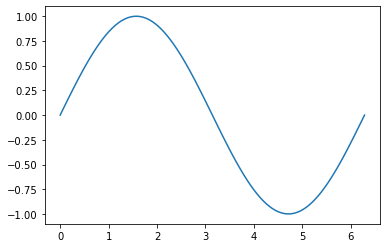

In [56]:
bazinga = np.linspace(0,2*np.pi,100)
double_bazinga = np.sin(bazinga)
plt.plot(bazinga,double_bazinga)
# plt.savefig('myimage.svg', format='svg', dpi=1200)

In [57]:
print((_h_[0]+_h_[ 1]+_h_[2]))

[2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5
 2.5 2.5 2.5]


C:\Users\Ganesh\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


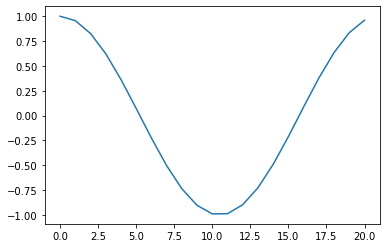

In [58]:
plt.plot(np.exp(-1j*t_))